In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dat = xr.open_dataset('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/Bellamite_538_R.nc')

In [15]:
dat.data_vars['DEPLOYMENT_LONGITUDE'].values

array('nan', dtype='<U3')

In [3]:
display(dat)

<xarray.Dataset> Size: 65MB
Dimensions:                                   (N_MEASUREMENTS: 415541,
                                               N_PARAM: 16)
Dimensions without coordinates: N_MEASUREMENTS, N_PARAM
Data variables: (12/51)
    TIME                                      (N_MEASUREMENTS) datetime64[ns] 3MB ...
    TIME_GPS                                  (N_MEASUREMENTS) datetime64[ns] 3MB ...
    PHASE                                     (N_MEASUREMENTS) float32 2MB ...
    PHASE_QC                                  (N_MEASUREMENTS) float32 2MB ...
    LATITUDE_GPS                              (N_MEASUREMENTS) float32 2MB ...
    LONGITUDE_GPS                             (N_MEASUREMENTS) float32 2MB ...
    ...                                        ...
    PLATFORM_TYPE                             <U6 24B ...
    PLATFORM_MODEL                            <U2 8B ...
    WMO_IDENTIFIER                            <U3 12B ...
    DEPLOYMENT_TIME                           datetime64[ns] 8B ...
    DEPLOYMENT_LATITUDE                       <U3 12B ...
    DEPLOYMENT_LONGITUDE                      <U3 12B ...
Attributes: (12/68)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              -54.43104
    geospatial_lat_max:              50.89405
    geospatial_lon_min:              -89.29212
    geospatial_lon_max:              -1.3952867
    ...                              ...
    instrument:                      ['Slocum G1+G2 Glider Navigation data lo...
    metadata_link:                   https://api.linked-systems.uk/api/meta/v...
    trajectory:                      Bellamite_20191206
    date_created:                    2024-04-08T15:08:06.115623
    date_modified:                   2024-04-08T15:08:06.115635
    id:                              Bellamite_20191206T000000_R

In [4]:
dat['TIME']

<xarray.DataArray 'TIME' (N_MEASUREMENTS: 415541)> Size: 3MB
[415541 values with dtype=datetime64[ns]]
Dimensions without coordinates: N_MEASUREMENTS
Attributes:
    long_name:                             time of measurement and gps location
    standard_name:                         time
    valid_min:                             1000000000.0
    valid_max:                             4000000000.0
    interpolation_methodology:             
    interpolation_methodology_vocabulary:  
    interpolation_methodology_doi:         
    sensor:

In [38]:
df_full = dat[['CHLA', 'PRES', 'BBP700', 'TIME']].to_dataframe()
df = df_full.dropna(subset = ['PRES', 'TIME'] ,how = 'all')

df['PRES'] = df['PRES'].interpolate()

In [39]:
df_full.shape[0]

415541

In [40]:
df.reset_index().set_index('TIME', inplace=True)

# Profile detection

## Detection of the ascent and descent instant speed of the glider

We will first compute the difference of depth between two points. the distribution of the values will indicate a potential breakpoint indicating of a change in the behaviour of the glider.

In [41]:
# Create an empty list to store profile values
diff_index = []
dfiff_time = 1
# Initialize the previous pressure value
prev_pres = 0
prev_time = None

speed_index = []

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    time = row['TIME']
    #Compute the difference of pressure
    diff = pres - prev_pres
    diff_index.append(diff)

    if prev_time is None:
        speed = diff
    else:
        diff_time = time - prev_time
        diff_time = diff_time.total_seconds()
        speed = diff/diff_time

    speed_index.append(speed)
    # Update the previous pressure value
    prev_pres = pres
    prev_time = time



# Add the diff values to the DataFrame
df['diff'] = diff_index
df['speed'] = speed_index

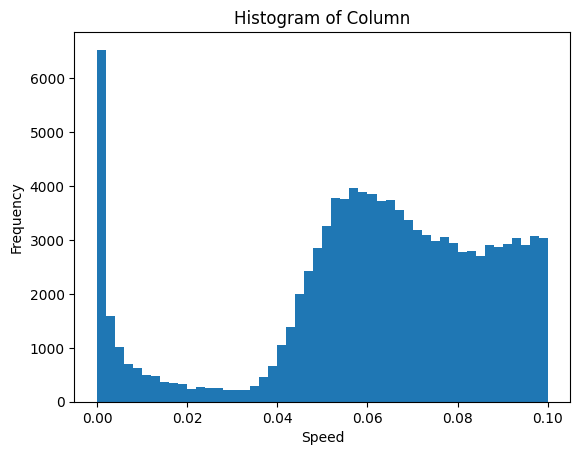

In [42]:
df['abs_diff'] = abs(df['diff'])
df['abs_speed'] = abs(df['speed'])
df_temp = df[df['abs_speed'] < 0.1]
plt.hist(df_temp['abs_speed'], bins=50)  # Adjust the number of bins as needed
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Histogram of Column')
plt.show()

Here, we observe that 0.5 seems to separate two subsample of glider speed. Let's look at the position of the glider when it reaches such position

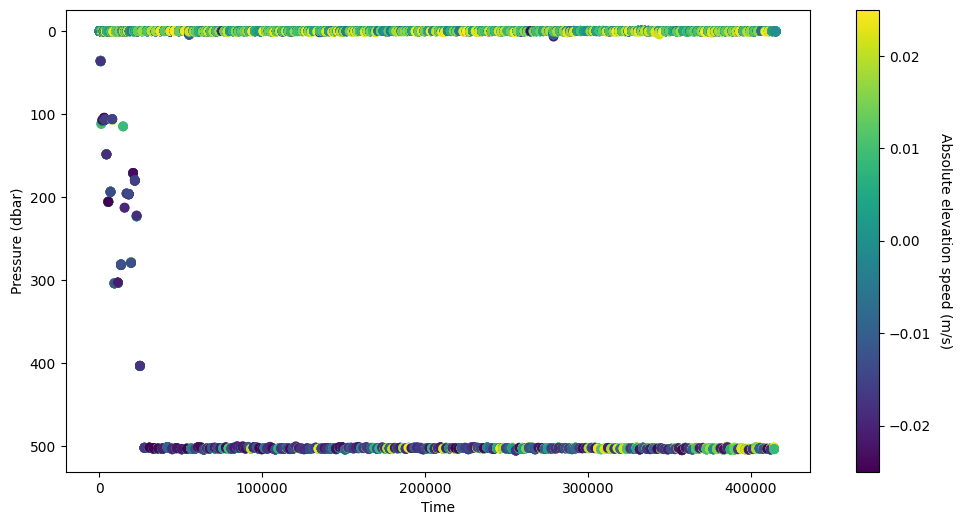

In [43]:
df1 = df[df['abs_speed'] < 0.025]


plt.figure(figsize=(12,6))
plt.scatter(x = df1.index, y = df1['PRES'], c = df1['speed'], cmap = 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Absolute elevation speed (m/s)', rotation=270, labelpad=15)

## Profile indexing
We will now compute a simple algorithm that attributes a profile index starting from 1. Every time the glider changes its direction the profile index is incremented by 1.

In [44]:
# Create an initial profile value
profile = 1

# Create an empty list to store profile values
profile_values = []
# Initialize the previous pressure value
prev_way = None

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    pres = row['PRES']
    speed = row['speed']
    if abs(speed) < 0.025:
        way = 'stationary'
    elif speed < 0:
        way = 'asc'
    else:
        way = 'desc'
    if way == 'stationary':
        profile_values.append(np.nan)
        way = prev_way
    elif prev_way is None or way == prev_way:
        profile_values.append(profile)
    else:
        profile += 1
        profile_values.append(profile)
    # Update the previous way value
    prev_way = way

# Add the profile values to the DataFrame
df['profile'] = profile_values

The profile can now be used as the index of the dataframe.

In [45]:
df = df.reset_index().set_index('profile')

We can check the success of the method by looking at the smallest profile and the largest ones.

In [46]:
check = df.index.value_counts()
check

profile
112.0    1783
97.0     1739
82.0     1649
111.0    1643
98.0     1557
         ... 
497.0       1
114.0       1
116.0       1
123.0       1
1.0         1
Name: count, Length: 598, dtype: int64

In [47]:
stationary = df[np.isnan(df.index)]

In [13]:
stationary.head()

,N_MEASUREMENTS,CHLA,PRES,BBP700,TIME,diff,speed
profile,,,,,,,
NaN,0,2.8764,0.000000,0.008601,2019-12-03 17:23:48.587585024,0.00000,0.000000
NaN,1,NaN,0.000610,NaN,2019-12-03 17:24:36.385161984,0.00061,0.000013
NaN,2,NaN,0.001220,NaN,2019-12-03 17:24:54.001831168,0.00061,0.000035
NaN,3,NaN,0.001829,NaN,2019-12-03 17:25:11.516540672,0.00061,0.000035
NaN,4,NaN,0.002439,NaN,2019-12-03 17:25:40.491607552,0.00061,0.000021


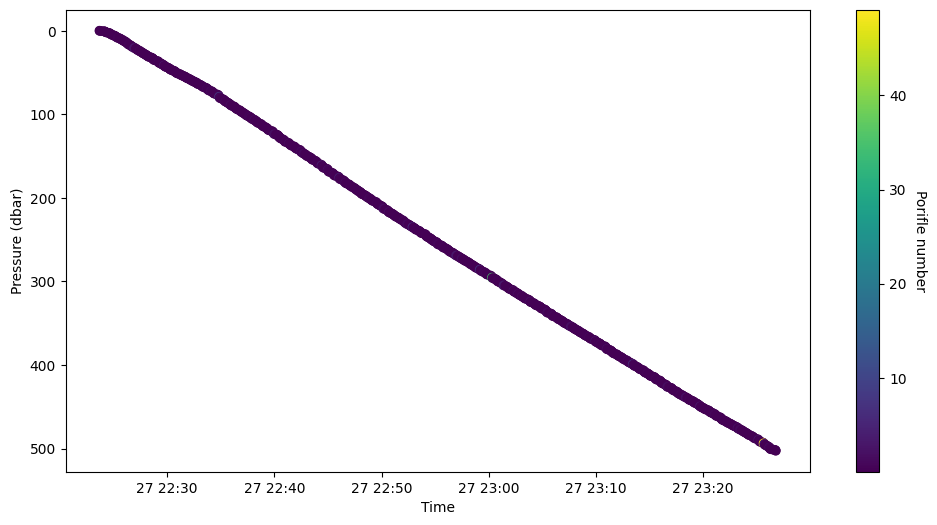

In [55]:
from matplotlib import colormaps
cmap = colormaps['Set1']

df1 = df.loc[499]
plt.figure(figsize=(12,6))
plt.scatter(x = df1['TIME'], y = df1['PRES'], c = df1['speed'], cmap = 'viridis')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Porifle number', rotation=270, labelpad=15)

In [19]:
date_min = df1['TIME'].min()
date_max = df1['TIME'].max()

stationary = stationary.reset_index().set_index('TIME')

stationary1 = stationary.loc[date_min:date_max]

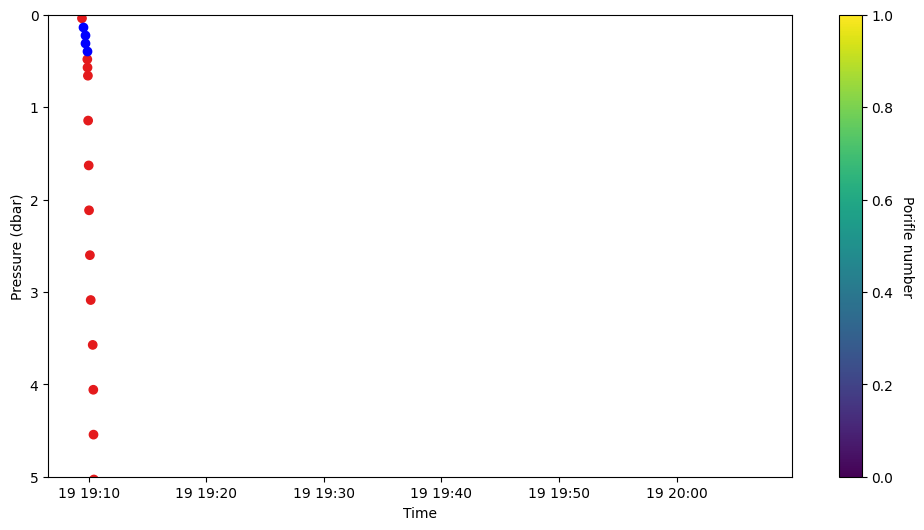

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(x = df1['TIME'], y = df1['PRES'], c = df1.index, cmap = cmap)
plt.scatter(x = stationary1.index, y = stationary1['PRES'], c = 'blue')
plt.ylim([0,5])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('Time')
cbar = plt.colorbar(label='profile')
cbar.set_label('Porifle number', rotation=270, labelpad=15)

In [ ]:
df_full = df_full[df_full['LONGITUDE'] < -88]
plt.figure(figsize=(12,6))
plt.scatter(x = df_full['LONGITUDE'], y = df_full['LATITUDE'], c=df_full['PRES'], cmap='viridis')
cbar = plt.colorbar(label='Index')
cbar.set_label('Pressure (dB)', rotation=270, labelpad=15)